In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [2]:
#overcast 20191030T161529_VOOR
#partly 20191112T183029_VOOR
#clear 20190511T122529_VOOR
PATH = '/home/arnold/clouds_detection/VOOR'
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
batch_size = 32
img_height = 720
img_width = 1080

1349


In [3]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [4]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/arnold/clouds_detection/VOOR/rain/20170426T152528_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/snow/20180302T164529_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/overcast/20190221T222029_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/few/20191102T213529_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/snow/20180302T164029_VOOR.jpg'


In [5]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['clear' 'few' 'night' 'overcast' 'rain' 'scattered' 'snow']


In [6]:
#split into training and val 
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [7]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


1080
269


In [8]:
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    one_hot = parts[-2] == class_names
  # Integer encode the label
    return tf.argmax(one_hot)

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
#     img = image.img_to_array(img)
    height, width, channels = img.shape
#     img = img[0:int(height/3), 0:width] #1/3 top 
    img = img[0:int(height/2), 0:width] #half
    print(img.shape)
    return img, label

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


(360, 1080, 3)
(360, 1080, 3)


In [12]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (360, 1080, 3)
Label:  6


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

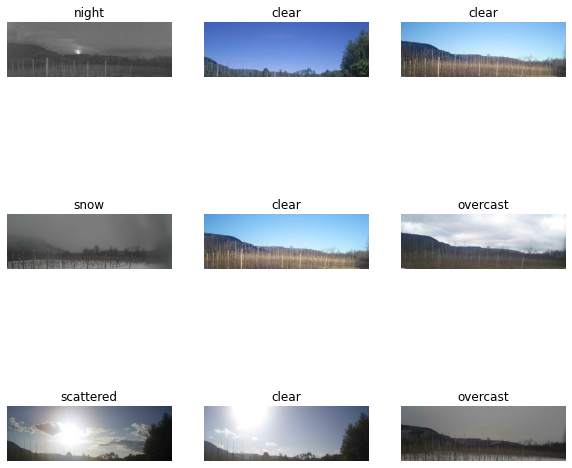

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)